In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu101
True


device(type='cuda', index=0)

## 读取数据

In [2]:
root_dir = r"../小型CSV数据/weather_dataset"
train_dir = os.path.join(root_dir, "train_dir")
test_dir = os.path.join(root_dir, "test_dir")

## 数据增强方法
- torchvision.transforms.RandomCrop() # 随机裁切
- torchvision.transforms.CenterCrop() # 中心裁切
- torchvision.transforms.RandomHorizontalFlip(p=0.5) # 随机水平翻转
- torchvision.transforms.RandomVerticalFlip(p=0.5) # 随机上下翻转
- torchvision.transforms.RandomRotation() # 随机旋转
- torchvision.transforms.ColorJitter(brightness=1) # 亮度
- torchvision.transforms.ColorJitter(contrast=1) # 对比度
- torchvision.transforms.ColorJitter(saturation=1) # 饱和度
- torchvision.transforms.ColorJitter(hue=1) # 颜色
- torchvision.transforms.RandomGrayscale(p=0.5) # 随机灰度化


In [3]:
from torchvision import transforms
traindata_transform_ops = transforms.Compose([
                             transforms.Resize(size=(224, 224)),
                             transforms.RandomCrop(size=(192, 192)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomRotation(degrees=0.2),
                             transforms.ColorJitter(brightness=0.5),
                             transforms.ColorJitter(contrast=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

testdata_transform_ops = transforms.Compose([
                             transforms.Resize(size=(192, 192)),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=traindata_transform_ops)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=testdata_transform_ops)
train_dataset.classes, train_dataset.class_to_idx, len(train_dataset)

(['cloudy', 'rain', 'shine', 'sunrise'],
 {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3},
 900)

In [4]:
traindata_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32,
                                               shuffle=True)
testdata_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=32)                                          

## 创建模型
- 对于微调，只有先训练好了最后的分类器层之后，才能微调卷积层

In [5]:
model = torchvision.models.resnet18(pretrained=True)

In [6]:
for param in model.parameters():
    param.requires_grad = False #冻结卷积部分的参数

In [7]:
in_features = model.fc.in_features
in_features

512

In [8]:
# 直接替换最后一层fc层, 直接定义的层的参数是可训练的
model.fc = torch.nn.Linear(in_features=in_features, out_features=4)
model.to(device=device)
# 前面的卷积层是被冻结了的，需要进行参数调整的就只是后面的分类层的参数，因此优化参数为model.classifier.parameters()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()
epochs = 10

In [9]:
from torch.optim import lr_scheduler
# 根据步数进行学习率衰减, step_size=5代表的是每隔5个epoch衰减一次
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.9)
mul_lr_scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[20, 50, 80], gamma=0.9)
expon_lr_scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7, last_epoch=-1)

## 训练代码

In [10]:
def fit(model, traindata_loader, testdata_loader, epoch):
    pred_corrected_num = 0
    total_num = 0
    training_batch_loss = 0
    # 由于存在dropout层，因此在训练和测试阶段是不同的效果的，因此使用model.train()来让模型知道接下来是在训练模式
    model.train() 
    for x, y in traindata_loader:
        x, y = x.to(device), y.to(device) # 将数据转移到GPU上
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            pred_corrected_num += (y_pred == y).sum().item()
            total_num += y.shape[0]
            training_batch_loss += loss.item()
    exp_lr_scheduler.step() # 记录步数，等步数等于exp_lr_scheduler中设定的步数时则进行衰减
    epoch_accuracy = pred_corrected_num / total_num
    epoch_loss = training_batch_loss / len(traindata_loader.dataset)
    #---------------------------------------------------------------
    test_pred_corrected_num = 0
    test_total_num = 0
    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in testdata_loader:
            x, y = x.to(device), y.to(device) # 将数据转移到GPU上
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_pred_corrected_num += (y_pred == y).sum().item()
            test_total_num += y.shape[0]
            test_batch_loss += loss.item()
    test_accuracy = test_pred_corrected_num / test_total_num
    test_loss = test_batch_loss / len(testdata_loader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
          "loss = ", round(epoch_loss, 3), 
          "accuracy = ", round(epoch_accuracy, 3),              
          "test_loss = ", round(test_loss, 3),
          "test_accuracy = ", round(test_accuracy, 3))
    return epoch_loss, epoch_accuracy, test_loss, test_accuracy

In [11]:
train_loss = []
train_accuracy = []
test_loss_ = []
test_accuracy_ = []

for epoch in range(epochs):
    epoch_loss, epoch_accuracy, test_loss, test_accuracy = fit(model, traindata_loader,
                                                               testdata_loader, epoch)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    test_loss_.append(test_loss)
    test_accuracy_.append(test_accuracy)

epoch =  0 loss =  0.048 accuracy =  0.228 test_loss =  0.052 test_accuracy =  0.231
epoch =  1 loss =  0.044 accuracy =  0.31 test_loss =  0.048 test_accuracy =  0.302
epoch =  2 loss =  0.04 accuracy =  0.396 test_loss =  0.043 test_accuracy =  0.409
epoch =  3 loss =  0.038 accuracy =  0.498 test_loss =  0.039 test_accuracy =  0.529
epoch =  4 loss =  0.035 accuracy =  0.58 test_loss =  0.036 test_accuracy =  0.578
epoch =  5 loss =  0.033 accuracy =  0.666 test_loss =  0.034 test_accuracy =  0.667
epoch =  6 loss =  0.031 accuracy =  0.689 test_loss =  0.032 test_accuracy =  0.72
epoch =  7 loss =  0.029 accuracy =  0.739 test_loss =  0.03 test_accuracy =  0.76
epoch =  8 loss =  0.027 accuracy =  0.787 test_loss =  0.027 test_accuracy =  0.822
epoch =  9 loss =  0.026 accuracy =  0.798 test_loss =  0.025 test_accuracy =  0.836


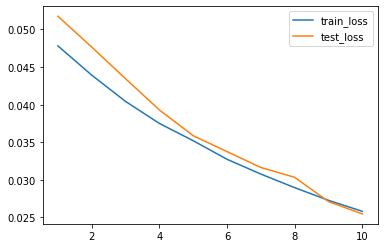

In [12]:
plt.plot(range(1, epochs+1), train_loss, label="train_loss")
plt.plot(range(1, epochs+1), test_loss_, label="test_loss")
plt.legend()

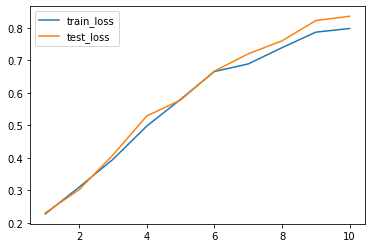

In [13]:
plt.plot(range(1, epochs+1), train_accuracy, label="train_loss")
plt.plot(range(1, epochs+1), test_accuracy_, label="test_loss")
plt.legend()